In [1]:
from transformers import AutoTokenizer
import torch

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from datasets import load_dataset,ClassLabel,Value,concatenate_datasets,Features,Array2D
import matplotlib.pyplot as plt
import numpy as np

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_diffusion_train = load_dataset("poloclub/diffusiondb","2m_first_10k")
dataset_diffusion_test = load_dataset("poloclub/diffusiondb","2m_random_5k")
dataset_imagenette = load_dataset("frgfm/imagenette","160px")

Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 78.08it/s]
Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_random_5k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 255.84it/s]
Found cached dataset imagenette (/home/hakim/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
100%|██████████| 2/2 [00:00<00:00, 190.93it/s]


In [3]:
train_db = dataset_diffusion_train["train"].select(range(9469))
val_db = dataset_diffusion_test["train"].select(range(1962))
test_db = dataset_diffusion_test["train"].select(range(1962,3925))

In [4]:
train_I = dataset_imagenette["train"]
val_I = dataset_imagenette["validation"].select(range(1962))
test_I = dataset_imagenette["validation"].select(range(1962,3925)) 

In [5]:
label_column = len(train_db) * [0]
train_db = train_db.add_column("label",label_column)
label_column = len(val_db) * [0]
val_db = val_db.add_column("label",label_column)
label_column = len(test_db) * [0]
test_db = test_db.add_column("label",label_column)

In [6]:
del_col = ['prompt','seed', 'step','cfg','sampler','width','height','user_name','timestamp','image_nsfw', 'prompt_nsfw']
train_db = train_db.remove_columns(del_col)
val_db = val_db.remove_columns(del_col)
test_db = test_db.remove_columns(del_col)

In [7]:
train_I = train_I.remove_columns("label")
val_I = val_I.remove_columns("label")
test_I = test_I.remove_columns("label")

In [8]:
label_column = len(train_I) * [1]
train_I = train_I.add_column("label",label_column)
label_column = len(val_I) * [1]
val_I = val_I.add_column("label",label_column)
label_column = len(test_I) * [1]
test_I = test_I.add_column("label",label_column)

In [9]:
train = concatenate_datasets([train_I,train_db])
val = concatenate_datasets([val_I,val_db])
test = concatenate_datasets([test_I,test_db])

In [14]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 18938
})

In [10]:
jitter = Compose(
    [ ToTensor(),Resize((160,160))]
)

In [11]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [ ]:
train_dataset = train.with_transform(transforms)
val_dataset = val.with_transform(transforms)
test_dataset = test.with_transform(transforms)

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [14]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader =  DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)

In [15]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc.out_features = 2

In [16]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
tr = model.train()

In [18]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [19]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
        
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss =running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))

In [20]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.136 | Accuracy: 97.333


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.022 | Accuracy: 99.134

Epoch : 2


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.020 | Accuracy: 99.424


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.015 | Accuracy: 99.414

Epoch : 3


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.005 | Accuracy: 99.836


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.016 | Accuracy: 99.567

Epoch : 4


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.007 | Accuracy: 99.810


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.008 | Accuracy: 99.771

Epoch : 5


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.006 | Accuracy: 99.836


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.012 | Accuracy: 99.592

Epoch : 6


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.015 | Accuracy: 99.583


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.010 | Accuracy: 99.822

Epoch : 7


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.002 | Accuracy: 99.931


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.002 | Accuracy: 99.975

Epoch : 8


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.002 | Accuracy: 99.926


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.002 | Accuracy: 99.949

Epoch : 9


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.002 | Accuracy: 99.942


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.003 | Accuracy: 99.949

Epoch : 10


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Train Loss: 0.003 | Accuracy: 99.916


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Val Loss: 0.011 | Accuracy: 99.541


In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for element in test_dataloader:
          # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Accuracy of the model on the test images: 99.89967261590454 %


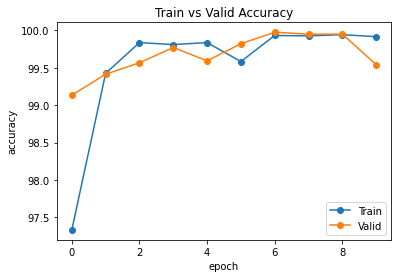

In [22]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

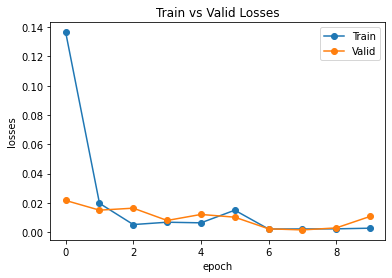

In [23]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [24]:
PATH = './binary.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import sleep
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = torchvision.models.resnet50()

In [ ]:
model.load_state_dict(torch.load("binary.pth"))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [25]:
classes = (0, 1)

In [63]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_dataloader:
        inputs = data["pixel_values"].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: ',classname, "is " f'{accuracy:.1f} %')

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Accuracy for class:  0 is100.0 %
Accuracy for class:  1 is99.8 %


In [28]:
from PIL import ImageFile, Image

image = Image.open('t.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([1], device='cuda:0')

In [29]:
image = Image.open('test.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([1], device='cuda:0')

In [30]:
image = Image.open('golf.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([1], device='cuda:0')

In [ ]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 18938
})

In [60]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 18938
})

In [64]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3926
})

1
tensor([1], device='cuda:0')


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


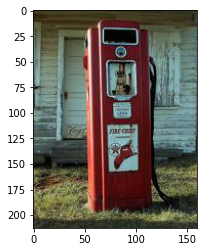

In [66]:
num = 23
print(train_dataset[num]["label"])
image = test_dataset[num]["image"]
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
print(predicted)
plot = plt.imshow(image)